**Instructors**: Prof. Antonio Ortega (aortega@usc.edu)

**Teaching Assistant**: Jiazhi Li (jiazhil@usc.edu)

**Book**: Watt, J., Borhani, R., & Katsaggelos, A. K. (2020). Machine learning refined: Foundations, algorithms, and applications. Cambridge University Press.

**Notebooks**: Written by Alexios Rustom (arustom@usc.edu) and based on the following **Github repository**: [notebooks](https://github.com/jermwatt/machine_learning_refined/tree/gh-pages/presentations/2nd_edition/jupyter%20%2B%20reveal.js%20version)

# Tree Based Learners

In [5]:
import numpy as np
import autograd.numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import seaborn as sns
import copy
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
readDataPath = '../readData/'

## The stump

The most basic tree-based universal approximator, the stump, is a simple step function with three parameters:

- two step levels or *leaf* parameters denoted by $v_1$ and $v_2$ (whose values are set independently of one another), and
- a split point parameter $s$ defining the boundary between the two levels.

$$
f\left(x\right)=\begin{cases}
\begin{array}{c}
v_{1}\\
v_{2}
\end{array} & \begin{array}{c}
x < s\\
x>s
\end{array}\end{cases}
$$    

## Creating deep trees via recursion

Given a depth one tree (a stump), each leaf can be recursively split up into two new leaves, introducing two new split points and creating a total of four distinct leaves.

- Using recursion we can construct deeper trees in a similar manner.

- The deeper a tree becomes the more capacity it gains, being able to take on a wider variety of shapes.

- In the following example, we visualize $4$ instances of a depth $D=2$ tree (top row) with $4$ instances of a depth $D=10$ tree where all parameters are set randomly.

In [6]:
## This code cell will not be shown in the HTML version of this notebook
def build_stump(s,L1,L2,x):
    stump = []
    for pt in x:
        if pt < s:
            stump.append(L1)
        else:
            stump.append(L2)
    stump = np.array(stump).flatten()
    return stump

In [7]:
def build_random_tree(D):
    x = np.linspace(0,1,100)
    fm = np.zeros((100,1)).flatten()
    for d in range(D):
        s = np.random.rand(1)
        L1 = np.random.randn(1)
        L2 = np.random.randn(1)
        new = build_stump(s,L1,L2,x)

        # add to current
        fm += new
    return fm

In [8]:
def plot_trees(D,num_instances):
    # figure
    fig = plt.figure(figsize = (9,3))
    x = np.linspace(0,1,100)

    # loop over and create instances
    for n in range(num_instances):
        # create tree
        fm = build_random_tree(D)

        # plot the current element
        ax = fig.add_subplot(1,num_instances,n+1)
        ax.plot(x,fm,c='r',zorder = 3,linewidth = 3)
        ax.set_title('$f$ ' + str(n),fontsize = 18)

        # clean up plot
        ax.grid(True, which='both')
        #ax.axis('off')
    plt.show()

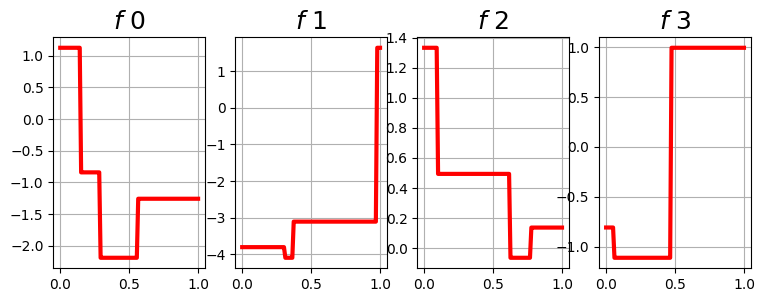

In [9]:
# use plotting tool
D = 2
num_stumps = D + 1
num_instances = 4
plot_trees(num_stumps,num_instances)

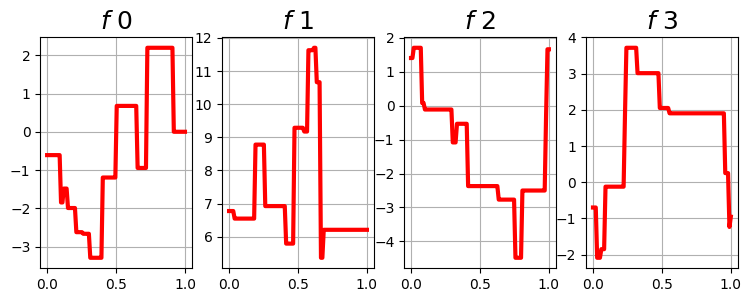

In [10]:
# use plotting tool
D = 10
num_stumps = D + 1
num_instances = 4
plot_trees(num_stumps,num_instances)

## Creating high capacity trees via addition

Deeper, more flexible trees can also be constructed via *addition* of shallower trees in general, and stumps in particular.

## Human interpretability

- Given their particularly simple structure, shallow tree-based units are often easy to interpret by humans, in comparison to their fixed-shape and neural network counterparts.

- However, this feature of tree-based units quickly dissipates as the depth of a tree is increased as well as when trees are combined or ensembled together.

## Regression Trees

In this Section we discuss the use of tree-based units for the problem of regression, often called *regression trees*.  Unlike kernel or neural network universal approximators, cost functions imbued with tree-based units create highly non-convex and often flat staircase-like cost functions that cannot be optimized directly via any local method.  Instead, trees must be fit to regression (and classification) data *recursively* in a heuristic manner.

###  Regression Stumps

- Tuning the parameters of a stump-based model by minimizing an appropiate cost function (e.g., the Least Squares) is generally very difficult.

- Not only is such a cost function non-convex, but it consists of staircase-like sections containing completely flat regions that no local optimization algorithm can navigate effectively.

- The problematic parameter producing this effect is always the *split-point*, regardless of how the leaf values are set.

### Determining proper split-points

- Note that, when the leaf values are fixed the corresponding Least Squares cost *stays at the exact same level when the split-point lies in-between the input of any two datapoints*.

- This means that - regardless of the values of a stump's leaves - its corresponding cost value will always *remain constant for split-point values in-between consecutive inputs*.  

- This fact has a very practical repercussion: we can always very easily find one candidate split-point per flat region since we need only take a point in-between each successive pair of inputs of our dataset, e.g., the *midpoint*.

### Determining optimal leaf values for a fixed split-point

- Since the leaves are *constant valued*, and we are using the stump as a nonlinear regressor, it makes intuitive sense to simply set the value of each leaf *to the mean of the points it will represent*.

- Indeed these intuitive choices for leaf values can be determined mechanically by minimizing the Least Squares cost employing a single stump model with fixed split-point.

Algebraically speaking, in general can set the leaf values of a stump $f$ with split-point $s$ defined along $n^{th}$ dimension of a dataset of $P$ points' input as

\begin{equation}
f\left(\mathbf{x}\right) =
\begin{cases}
\frac{1}{\vert \Omega_L \vert }\sum_{p \in \Omega_L}x_{p,n}    \,\,\,\,\,\, \text{if} \,\,\,\,\, x_n \leq s \\
\frac{1}{\vert \Omega_R \vert}\sum_{p \in \Omega_R}x_{p,n} \,\,\,\,\,\, \text{if} \,\,\,\,\,  x_n > s
\end{cases}
\end{equation}

where $\Omega_L$ and $\Omega_R$ are index sets containing those points from the training set whose $n^{th}$ dimension is less than / equal to or greater than the split point value respectively in other words

$$
\
\Omega_L = \left\{p \vert x_{p,n} \leq s  \right\} \\
\Omega_R = \left\{p \vert x_{p,n} > s  \right\}. \\
$$

### Determining optimal split-point and leaf values

Combining the two previous ideas provides a reasonable work-around way for tuning all three parameters of a stump to a regression dataset:

- We first create a set of candidate split-point values by recording every mid-point between our input data, along each of its dimensions.

- For each candidate split-point we determine the optimal stump, whose leaf values are set to the average of the training data output to the left and right of the split, and compute its (Least Squares) cost value.

- Doing this for all candidate split points, finally we keep the one that provides the *lowest* cost value.

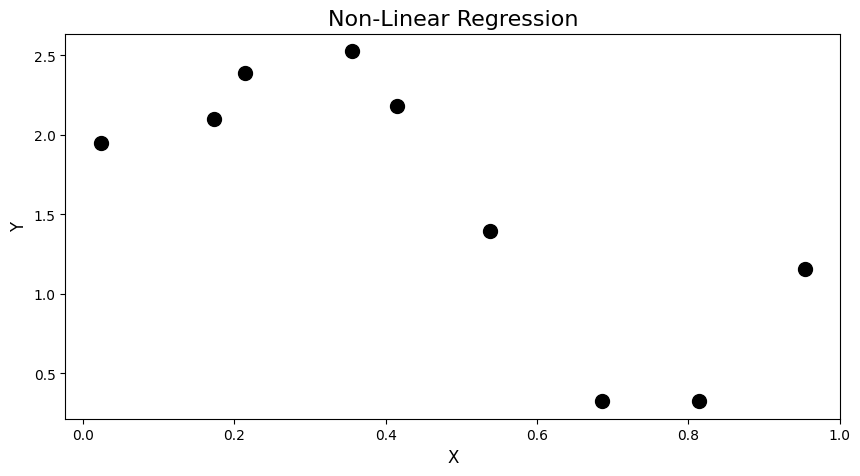

In [11]:
csvname = readDataPath + 'noisy_sin_subsample_raised_2.csv'
data = np.loadtxt(csvname,delimiter = ',')
x = data[:-1,:].T # up to last row (exclusive) of data & all columns
y = data[-1:,:].T # last row of data & all columns
plt.figure(figsize=(10, 5))
plt.scatter(x,y,s=100,facecolors='k', edgecolors='k')
plt.xlabel('X', fontsize = 12)
plt.ylabel('Y', fontsize = 12)
plt.title('Non-Linear Regression', fontsize=16)
plt.show()

In [12]:
def build_optimized_stump(s,L1,L2,x):
    stump = []
    for pt in x:
        if pt < s:
            stump.append(L1)
        else:
            stump.append(L2)
    stump = np.array(stump).flatten()
    return stump

In [13]:
def build_optimized_tree(D, s, L1, L2, x_stump):
    fm = np.zeros((x_stump.shape[0],1)).flatten()
    new = build_optimized_stump(s,L1,L2,x_stump)
    fm += new
    return fm

In [14]:
def plot_optimized_trees(D, s_array,x,y):
    fig = plt.figure(figsize = (20,5))
    n=0
    cost = []
    for s in s_array:
        left_array = []; right_array = [];
        counter = 0
        index_pt = [];
        for pt in x:
            if pt < s:
                left_array.append(y[counter][0])
                index_pt.append(0)
            else:
                right_array.append(y[counter][0])
                index_pt.append(1)
            counter = counter +1

        L1 = np.mean(left_array);
        L2 = np.mean(right_array)

        y_predicted = [L1 if i==0 else L2 for i in index_pt]
        x_stump = np.linspace(np.min(x),np.max(x),1000)

        fm = build_optimized_tree(D, s, L1, L2, x_stump)
        cost.append(mean_squared_error(y_predicted, y))
        ax = fig.add_subplot(2,4,n+1)
        ax.plot(x_stump,fm,c='r',zorder = 3,linewidth = 3)
        ax.scatter(x,y,s=50,facecolors='k', edgecolors='k')
        ax.set_title('s = ' + str(s),fontsize = 8)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.grid(False)
        n = n+1
    fig = plt.figure(figsize = (5,5))
    plt.plot(s_array,cost,'xb-')
    plt.xlabel('split point', fontsize=12)
    plt.ylabel('cost', fontsize=12)
    plt.show()

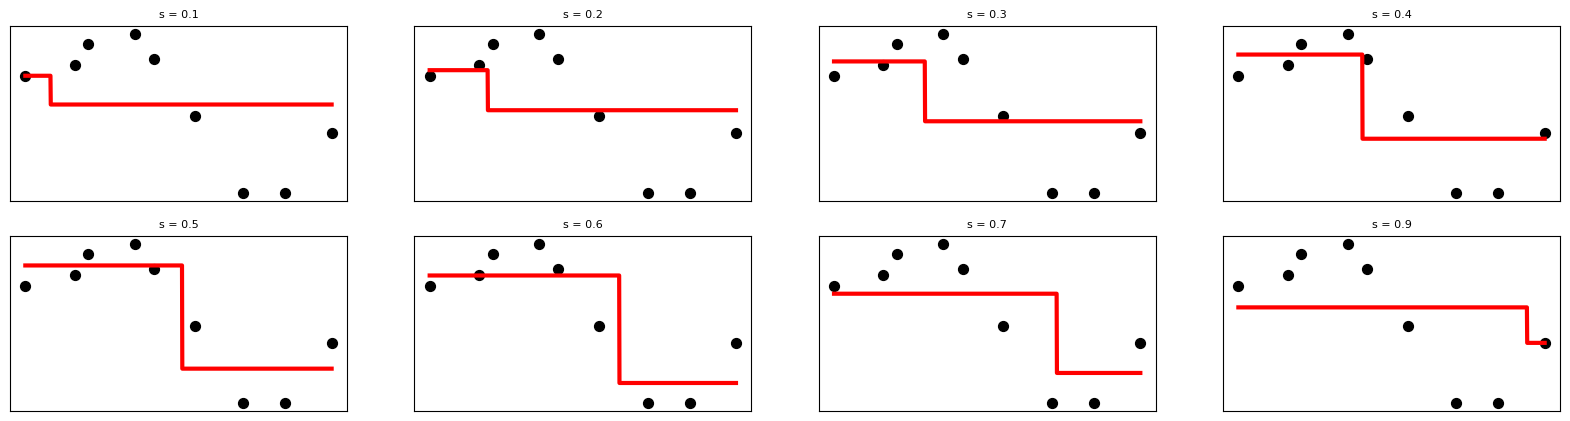

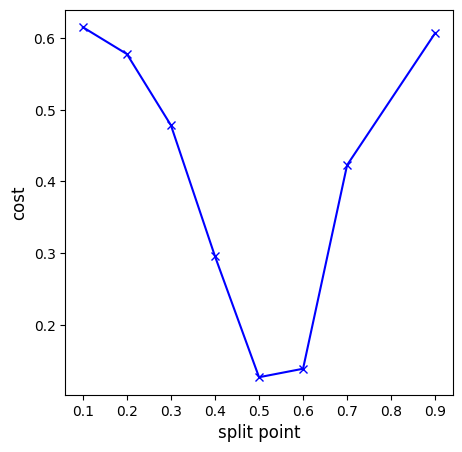

In [15]:
D = 1
s_array = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6,0.7, 0.9]
plot_optimized_trees(D, s_array,x,y)

###  Regression Trees of Maximum Depth

- To fit a depth two binary tree to a regression dataset we can first fit a stump, and then recurse on the same idea on each of the stump's leaves.

- We can then go on and repeat this process - splitting each leaf of our depth two tree, creating a depth three tree, and so on.

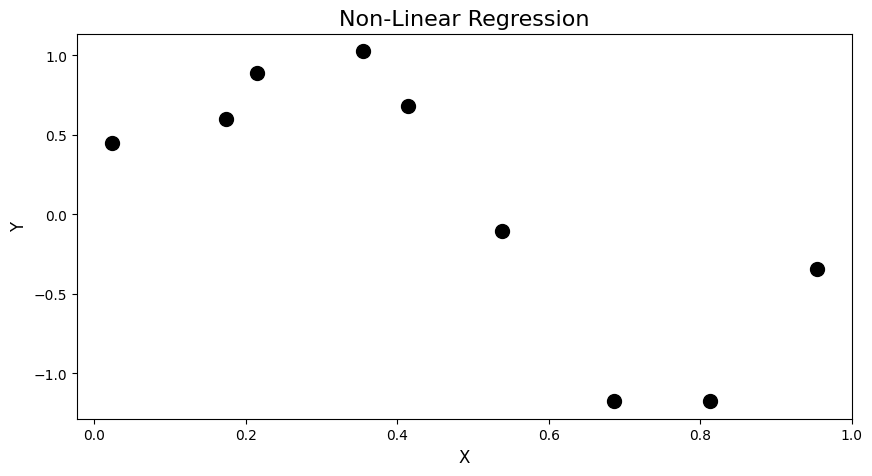

In [16]:
csvname = readDataPath + 'noisy_sin_subsample_2.csv'
data = np.loadtxt(csvname,delimiter = ',')
x = data[:-1,:].T # up to last row (exclusive) of data & all columns
y = data[-1:,:].T # last row of data & all columns
plt.figure(figsize=(10, 5))
plt.scatter(x,y,s=100,facecolors='k', edgecolors='k')
plt.xlabel('X', fontsize = 12)
plt.ylabel('Y', fontsize = 12)
plt.title('Non-Linear Regression', fontsize=16)
plt.show()

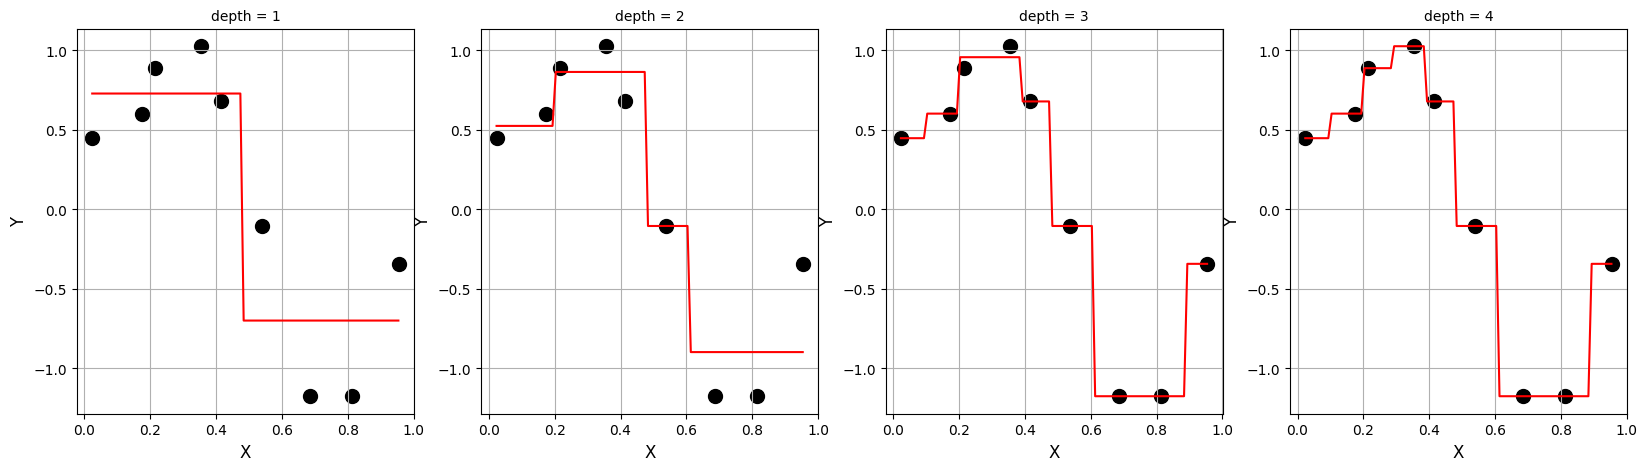

In [17]:
fig = plt.figure(figsize = (20,5))
n=0
for max_depth in [1,2,3,4]:
    regressor = DecisionTreeRegressor(random_state = 0, max_depth=max_depth)
    regressor.fit(x, y)
    ax = fig.add_subplot(1,4,n+1)
    X_grid = np.arange(min(x), max(x), 0.01)
    X_grid = X_grid.reshape((len(X_grid), 1))
    ax.plot(X_grid, regressor.predict(X_grid), color = 'red')
    ax.set_xlabel('X', fontsize = 12)
    ax.set_ylabel('Y', fontsize = 12)
    ax.scatter(x,y,s=100,facecolors='k', edgecolors='k')
    ax.set_title('depth = ' + str(max_depth),fontsize = 10)
    plt.grid(True, which='both')
    n=n+1
plt.show()

## Classification Trees

While we can apply regression trees directly to the problem of classification the fact that classification data has *discrete output* naturally provokes a unique application of binary trees to the problem of classification. With so-called *classification trees* we apply the same fundamental binary tree-based approximators, but with important differences in how both *leaf values* and *split-points* are chosen.

###  Classification Stumps

- For the same practical reasons described for regression we cannot use local optimization to determine an optimal choice for all parameters of a classification stump simultaneously.

- Instead we must again test out a variety of choices - different stumps consisting of different split-points and leaf values - in search of the ideal.

- Because the output of classification data is *discrete*, instead of assigning leaf values based on the *mean of the output* on either side of a split point, which can create numerical values that do not belong to either class, we can assign leaf values based on the *mode of the output* (the *majority vote*).

However with some dataset we can also see that there is a problem with using the *mode* as well: for every candidate stump (whose split-point is a midpoint between two consecutive inputs) the mode on *both sides* always equals $-1$ (i.e., every stump is *perfectly flat*).

In the right panel of the figure we show the data with each of its $9$ split-point highlighted by a vertical dashed blue line, with the (completely flat) stump found in each instance colored red.  

In other words, using the mode we cannot determine any of the nonlinear phenomenon present in this simple dataset.

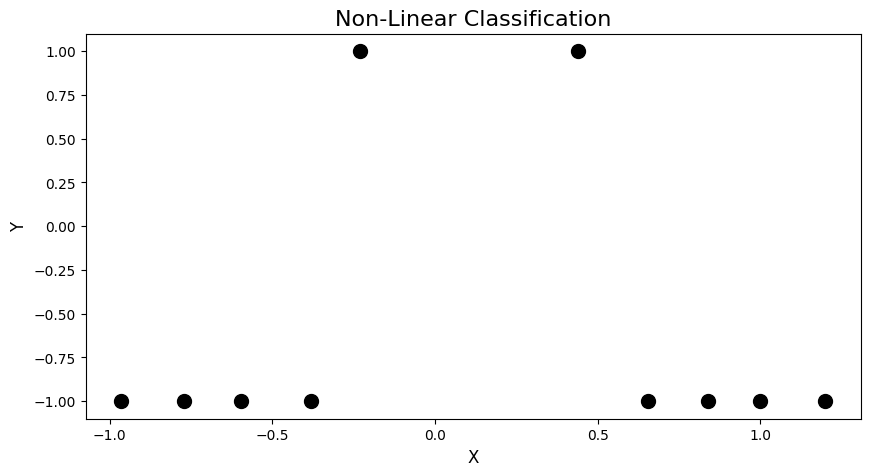

In [18]:
csvname = readDataPath + 'signed_projectile_2.csv'
data = np.loadtxt(csvname,delimiter = ',')
x = data[:-1,:].T # up to last row (exclusive) of data & all columns
y = data[-1:,:].T # last row of data & all columns
plt.figure(figsize=(10, 5))
plt.scatter(x,y,s=100,facecolors='k', edgecolors='k')
plt.xlabel('X', fontsize = 12)
plt.ylabel('Y', fontsize = 12)
plt.title('Non-Linear Classification', fontsize=16)
plt.show()

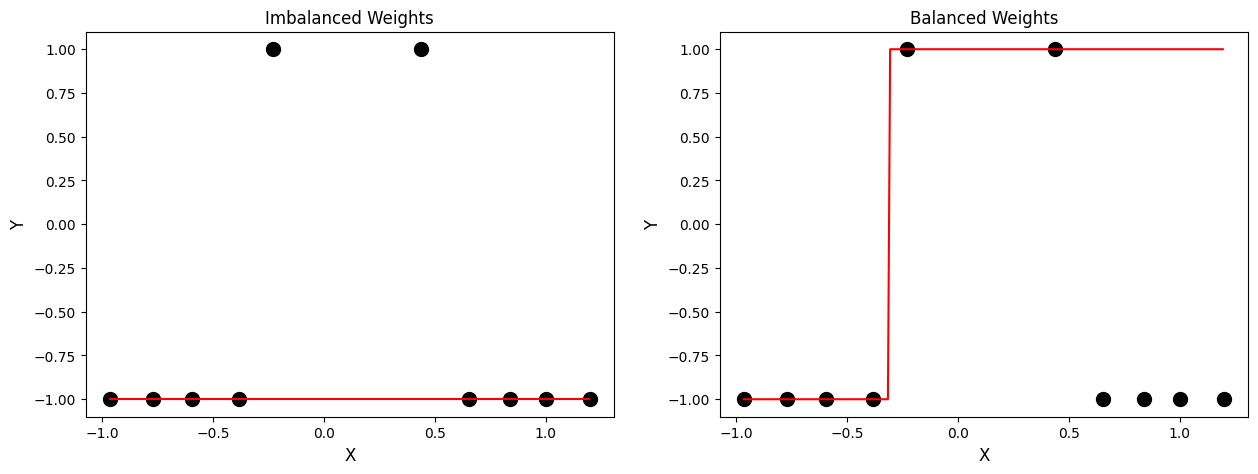

In [19]:
fig = plt.figure(figsize = (15,5))
n=0
for i in range(0,2):
    ax = fig.add_subplot(1,2,n+1)
    if (i==0):
        weights = {-1:1.0, 1:1.0}
    else:
        weights = {-1:1.0, 1:3.0}
    clf = DecisionTreeClassifier(random_state=0, criterion = 'gini', max_depth=1, class_weight = weights)
    clf = clf.fit(x,y)
    X_grid = np.arange(min(x), max(x), 0.01)
    X_grid = X_grid.reshape((len(X_grid), 1))
    y_pred = clf.predict(X_grid)
    ax.scatter(x,y,s=100,facecolors='k', edgecolors='k')
    ax.set_xlabel('X', fontsize = 12)
    ax.set_ylabel('Y', fontsize = 12)
    ax.plot(X_grid, y_pred, color = 'red')
    if (i==0):
        ax.set_title('Imbalanced Weights')
    else:
        ax.set_title('Balanced Weights')
    n=n+1
plt.show()

###  Classification Trees of Maximum Depth

To build deeper trees we recurse on the two leaves of a stump and treat each like we did the original data, building a stump out of each splitting them precisely as detailed above.

Just as with regression trees, with classification we have binary trees of a *maximum depth*, as certain branches halt under obvious and/or user-defined conditions.

- With classification, one natural halting condition is when a leaf is *completely pure*, that is it contains only members of a single class.

Other usef-defined halting conditions like a minimum number of points on a leaf are also often used in practice.

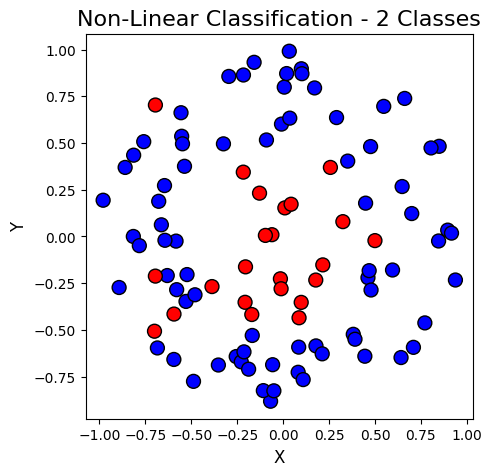

In [20]:
csvFile = readDataPath + 'new_circle_data.csv'
data = np.loadtxt(csvFile,delimiter = ',')
x = data[:-1,:].T
y = data[-1,:].T
data = pd.DataFrame(data)
data = data.T
data.columns=["X", "Y", "Label"]
plt.figure(figsize=(5, 5))
col = np.where(data["Label"]==1,'r','b')
plt.scatter(data["X"],data["Y"],s=100,c=col, edgecolors='k')
plt.xlabel('X', fontsize = 12)
plt.ylabel('Y', fontsize = 12)
plt.title('Non-Linear Classification - 2 Classes', fontsize=16)
plt.show()

In [21]:
print('Blue Counts (Label -1): ', len(np.where(data['Label']==-1)[0]))
print('Red Counts (Label 1): ',len(np.where(data['Label']==1)[0]))

Blue Counts (Label -1):  76
Red Counts (Label 1):  23


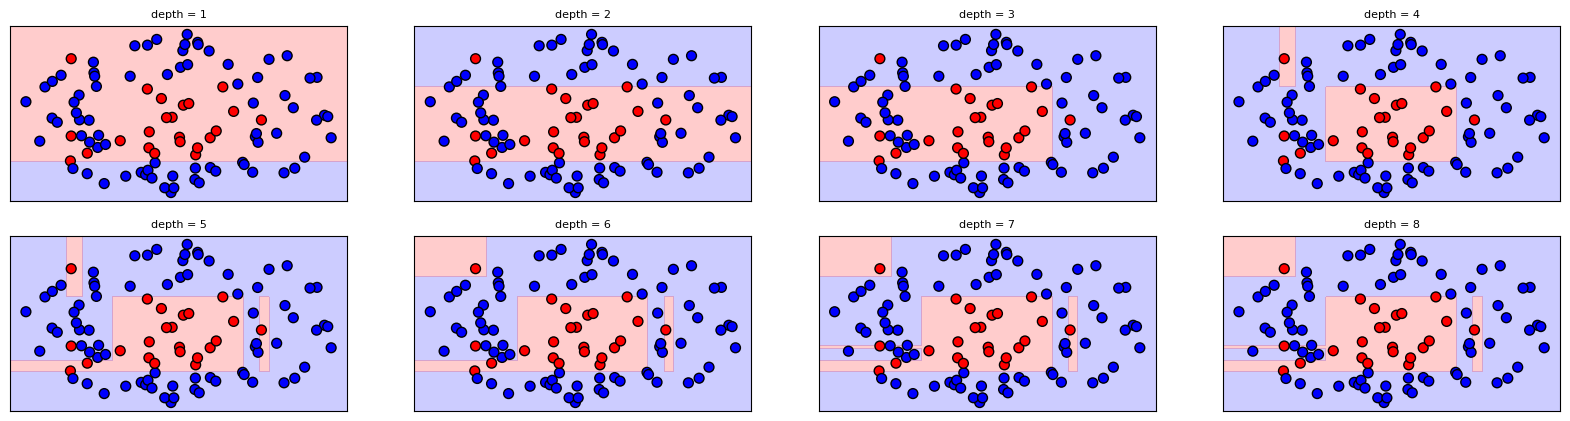

In [22]:
fig = plt.figure(figsize = (20,5))
x_min, x_max = x[:,0].min() - 0.1, x[:,0].max() + 0.1
y_min, y_max = x[:,1].min() - 0.1, x[:,1].max() + 0.1

h = 0.001
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
n=0
weights = {-1:1.0, 1:3.0}
for max_depth in [1,2,3,4,5,6,7,8]:
    clf = DecisionTreeClassifier(random_state=0, criterion = 'gini', max_depth=max_depth, class_weight=weights)
    clf = clf.fit(x,y)
    ax = fig.add_subplot(2,4,n+1)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z+1, levels = range(0,2+1), alpha=0.2, colors = ['blue', 'red'])
    #ax.set_xlabel('X', fontsize = 12)
    #ax.set_ylabel('Y', fontsize = 12)
    ax.scatter(x[:,0],x[:,1],s=50,facecolors='k', edgecolors='k', c=col )
    ax.set_title('depth = ' + str(max_depth),fontsize = 8)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False)
    n=n+1

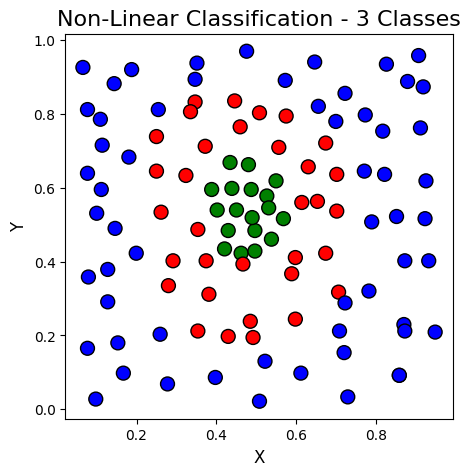

In [23]:
csvname = readDataPath + '3_layercake_data.csv'
data = np.loadtxt(csvname,delimiter = ',')
x = data[:-1,:].T
y = data[-1,:].T
data = pd.DataFrame(data)
data = data.T
data.columns=["X", "Y", "Label"]
plt.figure(figsize=(5, 5))
col_3C = np.where(data['Label']==0,'b',np.where(data['Label']==1,'r',np.where(data['Label']==2,'g', 'k')))
plt.scatter(data["X"],data["Y"],s=100,c=col_3C, edgecolors='k')
plt.xlabel('X', fontsize = 12)
plt.ylabel('Y', fontsize = 12)
plt.title('Non-Linear Classification - 3 Classes', fontsize=16)
plt.show()

In [24]:
print('Blue Counts (Label 0): ', len(np.where(data['Label']==0)[0]))
print('Red Counts (Label 1): ',len(np.where(data['Label']==1)[0]))
print('Green Counts (Label 2): ', len(np.where(data['Label']==2)[0]))

Blue Counts (Label 0):  59
Red Counts (Label 1):  33
Green Counts (Label 2):  18


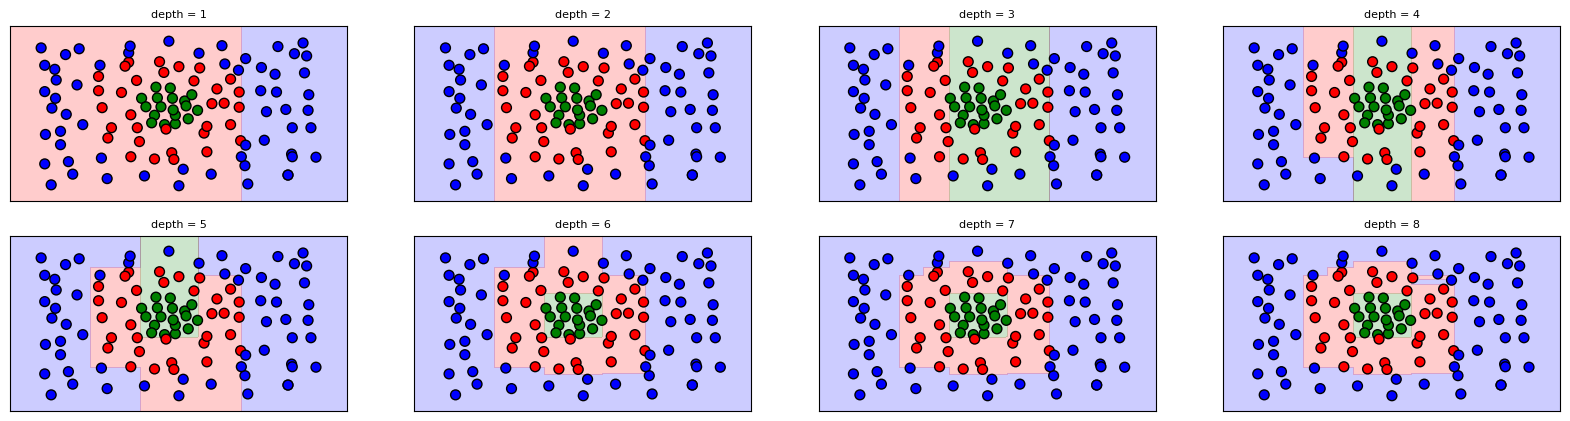

In [25]:
fig = plt.figure(figsize = (20,5))
x_min, x_max = x[:,0].min() - 0.1, x[:,0].max() + 0.1
y_min, y_max = x[:,1].min() - 0.1, x[:,1].max() + 0.1

h = 0.001
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
n=0
weights = {0:1.0, 1:2.0, 2:3.0}
for max_depth in [1,2,3,4,5,6,7,8]:
    clf = DecisionTreeClassifier(random_state=0, criterion = 'gini', max_depth=max_depth, class_weight=weights)
    clf = clf.fit(x,y)
    ax = fig.add_subplot(2,4,n+1)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z+1, levels = range(0,3+1), alpha=0.2, colors = ['blue', 'red', 'green'])
    #ax.set_xlabel('X', fontsize = 12)
    #ax.set_ylabel('Y', fontsize = 12)
    ax.scatter(x[:,0],x[:,1],s=50,facecolors='k', edgecolors='k', c=col_3C )
    ax.set_title('depth = ' + str(max_depth),fontsize = 8)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False)
    n=n+1

## Random Forests

- Unless human interpretability of the final model is of primary concern, one virtually never uses a single recursively defined regression or classification tree, but a bagged ensemble of them.

- Each individual tree can be trained on a random portion of training data taken from the original dataset and grown to a predetermined maximum depth, and afterwards bagged together.

- Such an ensemble of recursively defined trees is often called a "random forest."

The ”random” part of the name random forest refers both to the fact that:

- each tree uses a random portion of the original data as training (which, by convention, is often sampled from the original dataset with replacement)

- often only a random subset (something like $\sqrt{N}$) of $N$ input feature dimensions are sampled for viable split points at each node in the trees produced

- While trees can certainly overfit, even when not cross-validated they are naturally prevented from exhibiting the sort of wild oscillatory overfitting behavior that is readily possible with fixed-shape or neural network models.


- Moreover, because each fully grown tree in such an ensemble can be learned efficiently, the computational trade-off, that is, training a large number of fully grown trees compared with a smaller number of cross-validated ones (each of which require more resources to construct), is often advantageous in practice.

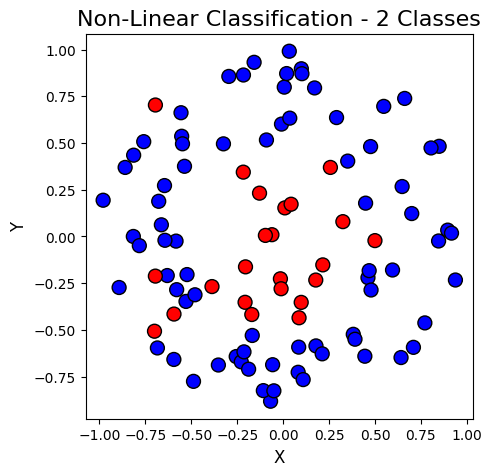

In [26]:
csvFile = readDataPath + 'new_circle_data.csv'
data = np.loadtxt(csvFile,delimiter = ',')
x = data[:-1,:].T
y = data[-1,:].T
data = pd.DataFrame(data)
data = data.T
data.columns=["X", "Y", "Label"]
plt.figure(figsize=(5, 5))
col = np.where(data["Label"]==1,'r','b')
plt.scatter(data["X"],data["Y"],s=100,c=col, edgecolors='k')
plt.xlabel('X', fontsize = 12)
plt.ylabel('Y', fontsize = 12)
plt.title('Non-Linear Classification - 2 Classes', fontsize=16)
plt.show()

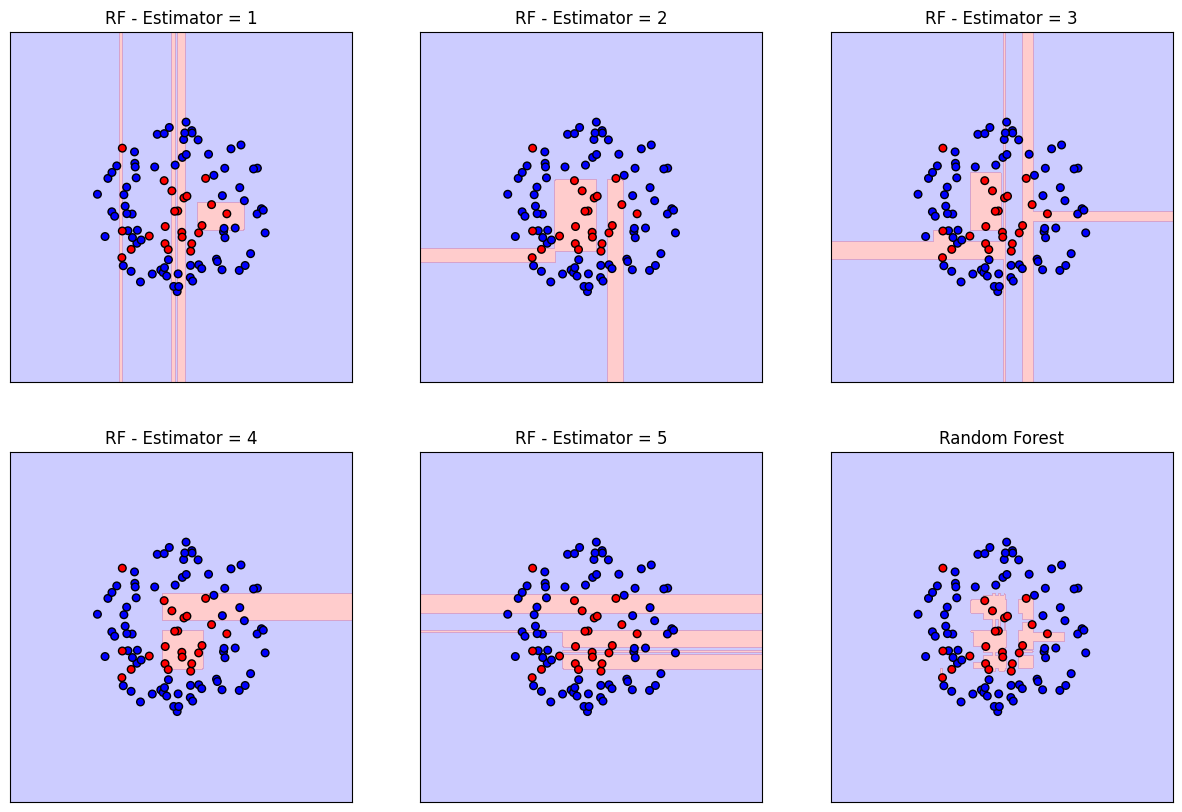

In [27]:
#rfc = RandomForestClassifier(n_estimators=rfc_random.best_params_['n_estimators'], max_depth=rfc_random.best_params_['max_depth'])
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33)
fig = plt.figure(figsize = (15,10))
n_estimators = 5
rfc = RandomForestClassifier(n_estimators=n_estimators, criterion='log_loss')
rfc.fit(X_train, y_train)
x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
h=0.01
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
n=0
for index_tree in range(n_estimators+1):
    ax = fig.add_subplot(2,3,n+1)
    if (n!=n_estimators):
        Z = rfc.estimators_[index_tree].predict(np.c_[xx.ravel(), yy.ravel()])
        ax.set_title('RF - Estimator = ' + str(index_tree+1),fontsize = 12)
    else:
        Z = rfc.predict(np.c_[xx.ravel(), yy.ravel()])
        ax.set_title('Random Forest',fontsize = 12)
    #Z = rfc.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z+1, levels = range(0,2+1), alpha=0.2, colors = ['blue', 'red'])
    ax.scatter(data["X"],data["Y"],s=30,c=col, edgecolors='k')
    ax.set_xticks([])
    ax.set_yticks([])
    n = n+1
plt.show()